In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
N = 365*20

beta_x = np.random.normal(2, size=N)# 2
beta_z = 1. / 25

z = np.random.normal(50, 10, size=N)
x = np.random.binomial(1, p=1/(1 + np.exp(-(z - z.mean())/z.std())))
p_true = 1/(1 + np.exp(-(z - z.mean())/z.std()))
y = np.random.poisson(beta_x*x + beta_z*z)

df = pd.DataFrame({'z': z, 'x': x, 'y': y})

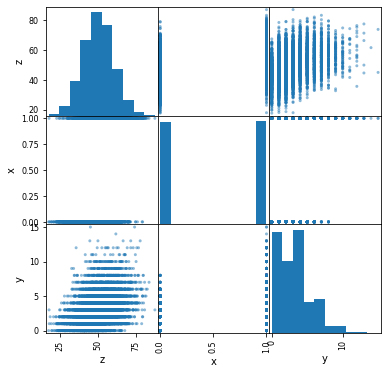

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(6,6));

In [ ]:
delta = df.groupby('x').mean()['y'][1] - df.groupby('x').mean()['y'][0]
delta

2.3965382699576563

In [ ]:
deltas = []
for _ in range(1000):
    sample_df = df.sample(n=len(df), replace=True).copy()
    delta = sample_df.groupby('x').mean()['y'][1] - sample_df.groupby('x').mean()['y'][0]
    deltas.append(delta)
deltas = pd.Series(deltas)

In [ ]:
deltas.mean() - 1.96 * deltas.std(), deltas.mean() + 1.96 * deltas.std()

(2.3114752713545275, 2.4845348686570277)

# First, we need a propensity score model

Let's use logistic regression.

In [ ]:
from statsmodels.discrete.discrete_model import Logit


df['intercept'] = 1
model = Logit(endog=df['x'], 
              exog=df[['z', 'intercept']])
result = model.fit()
result.summary()


Optimization terminated successfully.
         Current function value: 0.595938
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      x   No. Observations:                 7300
Model:                          Logit   Df Residuals:                     7298
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Feb 2021   Pseudo R-squ.:                  0.1402
Time:                        20:41:38   Log-Likelihood:                -4350.3
converged:                       True   LL-Null:                       -5059.9
Covariance Type:            nonrobust   LLR p-value:                1.471e-310
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
z              0.1042      0.003     32.881      0.000       0.098       0.110
intercept     -5.2013      0.160    -32.499      0.000      -5.515      -4.888
==============================================================================
"""

Don't forget -- we want the propensity of the actual state! Not propensity of treatment. We have to complement the probability for the $X=0$ state individuals.

In [ ]:
df['propensity_score'] = df['x'] * result.predict() + \
                         (1 - df['x']) * (1 - result.predict())

Now, we just use the weights in WLS regression. Statsmodels makes it easy (but be careful -- it will still run without the `weights` kwarg!)

In [ ]:
from statsmodels.api import WLS, OLS


df['intercept'] = 1
df['weight'] = 1. / df['propensity_score']
model = WLS(endog=df['y'], 
            exog=df[['x', 'intercept']],
            weights=df['weight']
           )
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.204
Model:                            WLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     1876.
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:47:06   Log-Likelihood:                -15524.
No. Observations:                7300   AIC:                         3.105e+04
Df Residuals:                    7298   BIC:                         3.107e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.9615      0.045     43.311      0.000       1.873       2.050
intercept      2.0117      0.032     62.725      0.000       1.949       2.075
==============================================================================
Omnibus:                      893.328   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1909.489
Skew:                           0.751   Prob(JB):                         0.00
Kurtosis:                       5.005   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We get a nice, de-biased estimate!

# Controlling for $Z$ as well.

In [ ]:
from statsmodels.api import GLM

df['intercept'] = 1
model = WLS(endog=df['y'], 
            exog=df[['x', 'z', 'intercept']],
            weight=df['weight']
           )
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.292
Model:                            WLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     1507.
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:45:04   Log-Likelihood:                -14998.
No. Observations:                7300   AIC:                         3.000e+04
Df Residuals:                    7297   BIC:                         3.002e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.9632      0.049     40.301      0.000       1.868       2.059
z              0.0418      0.002     16.892      0.000       0.037       0.047
intercept     -0.0772      0.117     -0.657      0.511      -0.308       0.153
==============================================================================
Omnibus:                      691.032   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1056.262
Skew:                           0.716   Prob(JB):                    4.32e-230
Kurtosis:                       4.191   Cond. No.                         272.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from statsmodels.api import GLM
from statsmodels.genmod.families.family import Poisson

In [ ]:
df['intercept'] = 1
model = GLM(endog=df['y'], 
            exog=df[['x', 'z', 'intercept']],
            family=Poisson(link=Poisson.links[1]()),
            link=Poisson.links[1](),
           )
result = model.fit()
result.summary()

/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 7300
Model:                            GLM   Df Residuals:                     7297
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14101.
Date:                Tue, 16 Feb 2021   Deviance:                       9071.2
Time:                        20:50:18   Pearson chi2:                 8.32e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.9696      0.044     44.353      0.000       1.883       2.057
z              0.0408      0.002     20.131      0.000       0.037       0.045
intercept     -0.0298      0.092     -0.326      0.745      -0.209       0.150
==============================================================================
"""

In [ ]:
df['intercept'] = 1
model = GLM(endog=df['y'], 
            exog=df[['x', 'z', 'intercept']],
            family=Poisson(link=Poisson.links[1]()),
            link=Poisson.links[1](),
            freq_weights=df['weight']
           )
result = model.fit()
result.summary()

/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 7300
Model:                            GLM   Df Residuals:                 14575.39
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28410.
Date:                Tue, 16 Feb 2021   Deviance:                       18191.
Time:                        20:50:27   Pearson chi2:                 1.67e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.9593      0.028     69.099      0.000       1.904       2.015
z              0.0424      0.001     31.598      0.000       0.040       0.045
intercept     -0.0954      0.066     -1.450      0.147      -0.224       0.034
==============================================================================
"""

# Using the BDA directly

In [ ]:
from statsmodels.api import GLM
from statsmodels.genmod.families.family import Poisson


df['intercept'] = 1
model = GLM(endog=df['y'], 
            exog=df[['x', 'z', 'intercept']],
            family=Poisson(link=Poisson.links[1]())
           )
result = model.fit()
result.summary()

/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 7300
Model:                            GLM   Df Residuals:                     7297
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14054.
Date:                Mon, 15 Feb 2021   Deviance:                       9036.4
Time:                        11:19:51   Pearson chi2:                 8.30e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              2.0350      0.044     45.989      0.000       1.948       2.122
z              0.0407      0.002     20.855      0.000       0.037       0.045
intercept     -0.0585      0.088     -0.664      0.507      -0.231       0.114
==============================================================================
"""

We should find a value of around $\delta=2.07$.

In [ ]:
df_1 = df.copy()
df_1['x'] = 1
df['y_pred_1'] = result.predict(exog=df_1[['x', 'z', 'intercept']])

In [ ]:
df_0 = df.copy()
df_0['x'] = 0
df['y_pred_0'] = result.predict(exog=df_0[['x', 'z', 'intercept']])

In [ ]:
(df['y_pred_1'] - df['y_pred_0']).mean()

2.035026955384659

In [ ]:
df['y_pred_0'].mean()

1.9735845745961853